
### Supervised Learning
### Activity: Building a Student Intervention System

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail or pass. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: ** 

*This is a question of classification, since the target variable takes only a set of values(in this case it is binomial, having the values of 'yes' and 'no'*

### Question-2
load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read student data
filename='student-data.csv'
data=pd.read_csv(filename)

In [200]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

### Question-3
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [3]:
# Calculate number of students
data_new= data.drop_duplicates()
data_new.shape

(395, 31)

*This shows that the number of data points in the dataset is 395, ie, number of samples, aka number of students = 395

#*Calculate number of features
As seen above, from the info method, and the shape attribute, it is evident that the number of features is 31-1 = 30, after excluding the target column "result"*


In [202]:
# Calculate passing students
pass_count=data[data['passed']=='yes'].shape[0]
print(pass_count)

265


*As shown above, the number of students who graduated is 265

In [203]:
# Calculate failing students
fail_count=data[data['passed']=='no'].shape[0]
print(fail_count)

130


In [204]:
# Calculate graduation rate
graduation_rate=(data[data['passed']=='yes'].shape[0])/data_new.shape[0]
print(graduation_rate)

0.6708860759493671


In [205]:
# Print the results
print("Total number of students: ",data_new.shape[0])
print("Total number of passed students: ",pass_count)
print("Total number of failed students: ",fail_count)
print("Rate of graduation of students: ",graduation_rate)

Total number of students:  395
Total number of passed students:  265
Total number of failed students:  130
Rate of graduation of students:  0.6708860759493671


## Preparing the Data
you will prepare the data for modeling, training and testing.

### Question-4 Identify feature and target columns


separate the student data into feature and target columns to see if any features are non-numeric.

In [206]:
# Extract feature columns

In [207]:
numer_list=list(data_new.select_dtypes(include=[np.number]).columns.values)
print("Numerical columns are: ")
print(*numer_list, sep=",")

Numerical columns are: 
age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences


In [208]:
all_list=list(data.columns.values)
print("All columns are: ")
print(*all_list, sep=",") 

All columns are: 
school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed


In [209]:
nonnum_list=[]
for i in np.arange(len(all_list)):
    if all_list[i] not in numer_list:
        nonnum_list.append(all_list[i])
    else:
        continue
                
print("Non-numerical columns are: ")
print(*nonnum_list, sep=",")

Non-numerical columns are: 
school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,passed


Text(0.5, 1.0, 'Distribution of Absences vs Passed-Indicator')

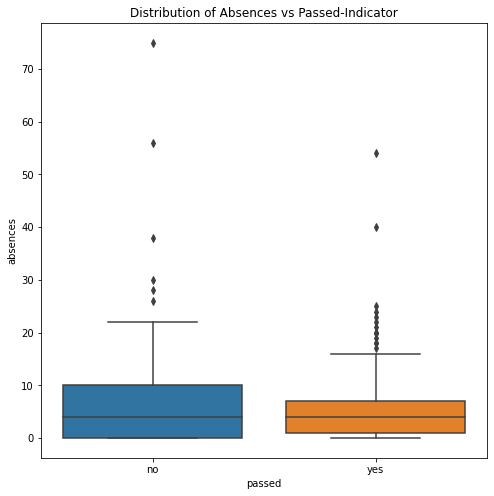

In [210]:
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(8,8))
#plt.title('Distribution of Absences vs Passed-Indicator',fontsize=16)
plt.xlabel('Passed')
plt.ylabel('Absences Count')
sns.boxplot(x=data_new['passed'],y=data_new['absences']).set_title("Distribution of Absences vs Passed-Indicator")

In [211]:
data_new['absences'].groupby(data_new['passed']).median()

passed
no     4
yes    4
Name: absences, dtype: int64

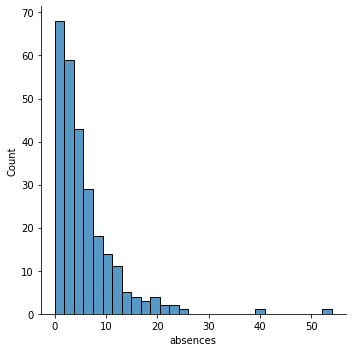

In [212]:
sns.displot(data.loc[data['passed']=='yes' ,'absences'])

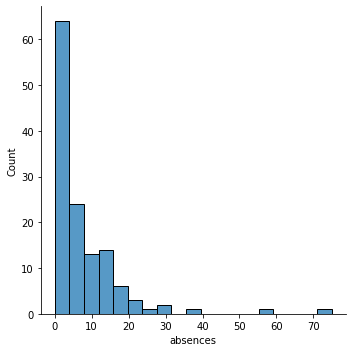

In [213]:
sns.displot(data.loc[data['passed']=='no' ,'absences'])

**It can be seen that the median value of the absences for both passed and failed students is 4. Also, since these are not normal distributions, we cannot remove outliers, but can only try and scale the statistical model to manage the variability**

In [214]:
age_values=pd.DataFrame(data_new.loc[data_new['passed']=='yes', 'age'].value_counts())
age_values.reset_index(inplace=True)
age_values=age_values.rename(columns={'age':'count','index':'age'})


In [215]:
age_values['total'] = age_values.apply(lambda row: (data_new.loc[data_new['age']== row.age,'age'].count()), axis=1)
age_values['proportion'] = age_values['count']/age_values['total']
age_values.sort_values('age', ascending=True, inplace=True)

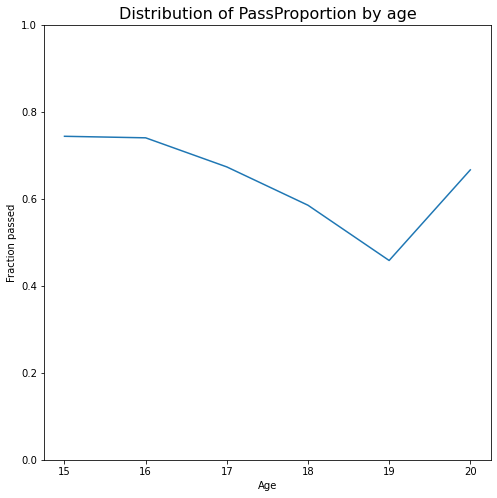

In [216]:
plt.figure(figsize=(8,8))
plt.title("Distribution of PassProportion by age",fontsize=16)
plt.xlabel('Age')
plt.ylabel('Fraction passed')
plt.plot(age_values['age'],age_values['proportion'])
plt.ylim(0,1)
plt.show()

**Similarly, the failed proportion in relation to age is as obtained below**

In [217]:
age_values_F=pd.DataFrame(data_new.loc[data_new['passed']=='no', 'age'].value_counts())
age_values_F.reset_index(inplace=True)
age_values_F=age_values_F.rename(columns={'age':'count','index':'age'})
age_values_F['total'] = age_values_F.apply(lambda row: (data_new.loc[data_new['age']== row.age,'age'].count()), axis=1)
age_values_F['proportion'] = age_values_F['count']/age_values_F['total']
age_values_F.sort_values('age', ascending=True, inplace=True)

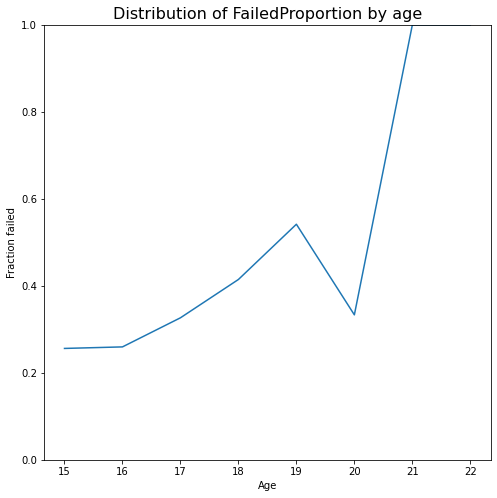

In [218]:
plt.figure(figsize=(8,8))
plt.title("Distribution of FailedProportion by age",fontsize=16)
plt.xlabel('Age')
plt.ylabel('Fraction failed')
plt.plot(age_values_F['age'],age_values_F['proportion'])
plt.ylim(0,1)
plt.show()

**Going by the graph above, it seems a good idea to drop rows with age=21 or 22, if the count is very small(which in our dataset is only 2), so that after onehot encoding of the age column, the number of features is slightly less than if the row is not dropped**

In [4]:
data_new.loc[(data_new['age']==21) | (data_new['age']==22)].index

Int64Index([247, 392], dtype='int64')

In [5]:
data_new.drop([247,392], inplace=True)

In [221]:
# Extract target column 'passed'

In [222]:
# Separate the data into feature data and target data (X and y, respectively)

In [6]:
X=data_new.drop('passed',axis=1)
y=data_new['passed']

### Question-5 Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [7]:
X.shape

(393, 30)

**We shall apply minmax scaling on the feature absences and then onehot encode all the remaining features**

In [8]:
from sklearn import preprocessing
minmax = preprocessing.MinMaxScaler(feature_range=(0, 1))
X[['absences']] = minmax.fit_transform(X[['absences']])

In [9]:
X['absences']

0      0.080000
1      0.053333
2      0.133333
3      0.026667
4      0.053333
         ...   
389    0.000000
390    0.146667
391    0.040000
393    0.000000
394    0.066667
Name: absences, Length: 393, dtype: float64

In [10]:
X_temp=pd.get_dummies(X, columns=['age','Medu','Fedu','traveltime','studytime','failures','famrel','freetime','goout','Dalc','Walc','health','school','sex','address','famsize','Pstatus','Mjob','Fjob','reason','guardian','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic'])

In [11]:
X_temp.shape

(393, 102)

In [12]:
print(list(X_temp.columns.values),sep=",")

['absences', 'age_15', 'age_16', 'age_17', 'age_18', 'age_19', 'age_20', 'Medu_0', 'Medu_1', 'Medu_2', 'Medu_3', 'Medu_4', 'Fedu_0', 'Fedu_1', 'Fedu_2', 'Fedu_3', 'Fedu_4', 'traveltime_1', 'traveltime_2', 'traveltime_3', 'traveltime_4', 'studytime_1', 'studytime_2', 'studytime_3', 'studytime_4', 'failures_0', 'failures_1', 'failures_2', 'failures_3', 'famrel_1', 'famrel_2', 'famrel_3', 'famrel_4', 'famrel_5', 'freetime_1', 'freetime_2', 'freetime_3', 'freetime_4', 'freetime_5', 'goout_1', 'goout_2', 'goout_3', 'goout_4', 'goout_5', 'Dalc_1', 'Dalc_2', 'Dalc_3', 'Dalc_4', 'Dalc_5', 'Walc_1', 'Walc_2', 'Walc_3', 'Walc_4', 'Walc_5', 'health_1', 'health_2', 'health_3', 'health_4', 'health_5', 'school_GP', 'school_MS', 'sex_F', 'sex_M', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 're

**We can see that along with the original 'absences' column, we have the dummies for all other columns**
**Now we can reassign X_temp back to X and proceed with model creation**

In [13]:
X=X_temp

### Question - 6 Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. you will need to implement the following:
- Randomly shuffle and split the data (`X`, `y`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [14]:
# splitting the data into train and test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42, test_size=0.25)

In [15]:
X_train.shape

(294, 102)

In [16]:
X_test.shape

(99, 102)

*Show the results of the split*

**We can see that out of 393 data points, 294 have gone to training and 99 have gone to testing**


### Question - 7  Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data and measure the accuracy score.

###  Model Application
*List three supervised learning models that are appropriate for this problem. What are the general applications of each model? What are their strengths and weaknesses? Given what you know about the data, why did you choose these models to be applied?*

In [234]:
#explaination
#Models that are appropriate for this problem are LogisticRegression, KNN, and RandomForest since the number of 
#samples is less than 1000, and the number of features is less than 1000 also.

**Logistic Regression vs KNN :**
1. KNN is a non-parametric model, where LR is a parametric model.
2. KNN is comparatively slower than Logistic Regression.
3. KNN supports non-linear solutions where LR supports only linear solutions.
4. LR can derive confidence level (about its prediction), whereas KNN can only output the labels.

**Decision tree(from which Random forest is derived) vs KNN :**
1. Both are non-parametric methods.
2. Decision tree supports automatic feature interaction, whereas KNN cant.
3. Decision tree is faster due to KNN’s expensive real time execution.

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [235]:
# Import the three supervised learning models from sklearn


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [236]:
# fit model-1  on traning data 

In [237]:
logit_model=LogisticRegression(solver='lbfgs', max_iter=500)
logit_model.fit(X_train,y_train)
y_pred=logit_model.predict(X_test)
print("Accuracy is: ",accuracy_score(y_test,y_pred))
print("Precision is: ", precision_score(y_test,y_pred, average='macro'))
print("Recall is: ", recall_score(y_test,y_pred, average='macro'))
print("f1 score is: ", f1_score(y_test,y_pred, average='macro'))

Accuracy is:  0.7070707070707071
Precision is:  0.6818181818181819
Recall is:  0.6375
f1 score is:  0.6427771556550952


In [238]:
# predict on the test data 

In [239]:
print("Confusion matrix: \n", confusion_matrix(y_test,y_pred))

Confusion matrix: 
 [[14 21]
 [ 8 56]]


In [240]:
# calculate the accuracy score
#Now, proceeding to the KNN method, we first find the appropriate K value to take by first assuming k between 3 and 15
acc_values=[]
neighbors = np.arange(3,15)
for k in neighbors:
    classifier = KNeighborsClassifier(n_neighbors=k, metric='minkowski')
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    acc=accuracy_score(y_test,y_pred)
    acc_values.append(acc)

Text(0, 0.5, 'accuracy')

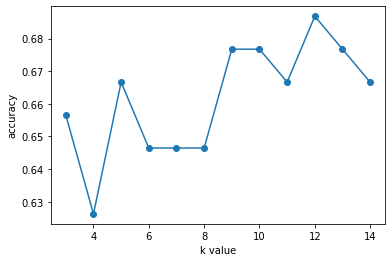

In [241]:
plt.plot(neighbors,acc_values, 'o-')
plt.xlabel('k value')
plt.ylabel('accuracy')

**The above graph shows that the accuracy value is highest for k=12. So, we shall proceed to build the model using that value**

In [242]:
# fit the model-2 on traning data and predict on the test data and measure the accuracy

In [243]:
classifier = KNeighborsClassifier(n_neighbors=12, metric='minkowski')
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
print("Accuracy is: ",accuracy_score(y_test,y_pred))
print("Precision is: ", precision_score(y_test,y_pred, average='macro'))
print("Recall is: ", recall_score(y_test,y_pred, average='macro'))
print("f1 score is: ", f1_score(y_test,y_pred, average='macro'))
print("Confusion matrix: \n", confusion_matrix(y_test,y_pred))

Accuracy is:  0.6868686868686869
Precision is:  0.7156593406593407
Recall is:  0.5700892857142857
f1 score is:  0.5395348837209302
Confusion matrix: 
 [[ 6 29]
 [ 2 62]]


In [244]:
# fit the model-3 on traning data and predict on the test data and measure the accuracy

In [249]:
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
print("Accuracy is: ",accuracy_score(y_test,y_pred))
print("Precision is: ", precision_score(y_test,y_pred, average='macro'))
print("Recall is: ", recall_score(y_test,y_pred,average='macro'))
print("f1 score is: ", f1_score(y_test,y_pred,average='macro'))
print("Confusion matrix: \n", confusion_matrix(y_test,y_pred))

Accuracy is:  0.7272727272727273
Precision is:  0.7516806722689076
Recall is:  0.6337053571428571
f1 score is:  0.6338857690727298
Confusion matrix: 
 [[11 24]
 [ 3 61]]


# The results 
# Logistic regression: 70 right vs 29 wrong
# KNN: 68 right vs 31 wrong
# Random Forest 72 right vs 27 wrong

**Now, for the feature importance as per random forest**

In [250]:
pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)*100

absences      6.275570
failures_0    3.781384
failures_2    1.475842
goout_4       1.465900
health_3      1.459746
                ...   
Dalc_5        0.197848
famrel_1      0.058779
Medu_0        0.037300
Fedu_0        0.012510
age_20        0.000000
Length: 102, dtype: float64

**This implies that the important features that RandomForest has identified, which affect the "passed" outcome, are absences, failures =0 (number of past class failures), failures=2(number of past class failures), goout=4(frequently goes out with friends) and health=3(moderate health)**

**Gradient Booster**

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
gb=GradientBoostingClassifier()
gb.fit(X_train,y_train)
y_pred=gb.predict(X_test)
print("Accuracy is: ",accuracy_score(y_test,y_pred))
print("Precision is: ", precision_score(y_test,y_pred, average='macro'))
print("Recall is: ", recall_score(y_test,y_pred, average='macro'))
print("f1 score is: ", f1_score(y_test,y_pred, average='macro'))
print("Confusion matrix: \n", confusion_matrix(y_test,y_pred))

Accuracy is:  0.7474747474747475
Precision is:  0.7341666666666666
Recall is:  0.6881696428571429
f1 score is:  0.6982075356663822
Confusion matrix: 
 [[17 18]
 [ 7 57]]


In [20]:
pd.Series(gb.feature_importances_,index=X.columns).sort_values(ascending=False)*100

absences       14.441411
failures_0     10.567382
freetime_1      4.058920
Fedu_3          3.320434
health_3        3.222303
                 ...    
Medu_0          0.000000
age_20          0.000000
studytime_4     0.000000
famrel_2        0.000000
famrel_1        0.000000
Length: 102, dtype: float64